In [ ]:
%ls

CS682_Assignment_1_eda569d4-59ae-4cda-839d-0199f048837e.ipynb
requirements.txt


In [ ]:
import sys
print(sys.executable)

/usr/local/bin/python3


In [ ]:
%pip install -r requirements.txt

In [ ]:
%pip install qiskit-aer

In [26]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [12]:
import qiskit
from qiskit import QuantumCircuit
print(qiskit.__version__)

2.1.2


# Question 1

Consider the boolean function $\mathrm{OR}: \{0,1\}^2 \rightarrow \{0,1\}$ that outputs 1 if at least one of its inputs is 1. The truth table for it is :

<table>
    <tr>
        <th>$x_0$</th>
        <th>$x_1$</th>
        <th>$\mathrm{OR}(x_0, x_1)$</th>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td>1</td>
        <td>1</td>
    </tr>
    <tr>
        <td>1</td>
        <td>0</td>
        <td>1</td>
    </tr>
    <tr>
        <td>1</td>
        <td>1</td>
        <td>1</td>
    </tr>
</table>

Similarly, we have the boolean function $\mathrm{AND}: \{0,1\}^2 \rightarrow \{0,1\}$ that outputs 1 if both of its inputs is 1. The truth table for it is :

<table>
    <tr>
        <th>$x_0$</th>
        <th>$x_1$</th>
        <th>$\mathrm{AND}(x_0, x_1)$</th>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td>1</td>
        <td>0</td>
    </tr>
    <tr>
        <td>1</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>1</td>
        <td>1</td>
        <td>1</td>
    </tr>
</table>

We want to extend the above two boolean functions into two quantum gates $\mathrm{X_{OR}}$ and $\mathrm{X_{AND}}$ respectively, such that 

$\hspace{4cm}\mathrm{X_{OR}} |a\rangle |b\rangle |c\rangle\ =\ |a\rangle |b\rangle |c\oplus \mathrm{OR}(a,b)\rangle,\ \forall a, b, c \in \{0,1\},\hspace{0.2cm}$ and

$\hspace{4cm}\mathrm{X_{AND}} |a\rangle |b\rangle |c\rangle\ =\ |a\rangle |b\rangle |c\oplus \mathrm{AND}(a,b)\rangle,\ \forall a, b, c \in \{0,1\}$.

<ol style="list-style-type:lower-alpha">
    <li>Construct the 8x8 matrices representing these quantum gates.</li>
    <li>Convert these matrices into quantum gates with the help of the $\texttt{Operator}$ function from the library $\texttt{qiskit.quantum\_info}$, and build circuits using them.</li>
    <li>Plot a histogram of 10,000 measurements over different inputs to show that the quantum gates that you constructed indeed work correctly.</li>
</ol>

In [15]:
def transform_to_binary_matrix(M, num_bits):

    res = [[0] * num_bits for _ in range(len(M))]
    for idx, num in enumerate(M):
        for i in range(num_bits):
            r = num % 2
            res[idx][num_bits - 1 - i] = r
            num >>= 1
    
    return res
    

In [16]:
def one_hot_encode_matrix(M):
    
    M = np.array(M)
    res = np.zeros((M.size, M.max() + 1))
    res[np.arange(M.size), M] = 1
    return res

In [37]:
OR = []
AND = []
inputs = []
for a in [0, 1]:
    for b in [0, 1]:
        for c in [0, 1]:
            num = (1 << 2) * a + (1 << 1) * b + (1 << 0) * (c ^ (a or b))
            OR.append(num)
            num = (1 << 2) * a + (1 << 1) * b + (1 << 0) * (c ^ (a and b))
            AND.append(num)
            inputs.append((a, b, c))
# M_or = transform_to_binary_matrix(OR, 3)
M_or = one_hot_encode_matrix(OR)
M_and = one_hot_encode_matrix(AND)

In [18]:
M_or = np.array(M_or).T
M_and = np.array(M_and).T
assert(M_or.shape == (8, 8) and M_and.shape == (8, 8))

In [24]:
Op_or = Operator(M_or)
Op_and = Operator(M_and)
print(f"OR Operator is {'an' if Op_or.is_unitary() else 'not an'} unitary")
print(f"AND Operator is {'an' if Op_and.is_unitary() else 'not an'} unitary")

OR Operator is an unitary
AND Operator is an unitary



AND counts (t bit):
00 {'0': 10000}
01 {'0': 10000}
10 {'0': 10000}
11 {'0': 10000}

OR counts (t bit):
00 {'0': 10000}
01 {'0': 10000}
10 {'0': 10000}
11 {'0': 10000}


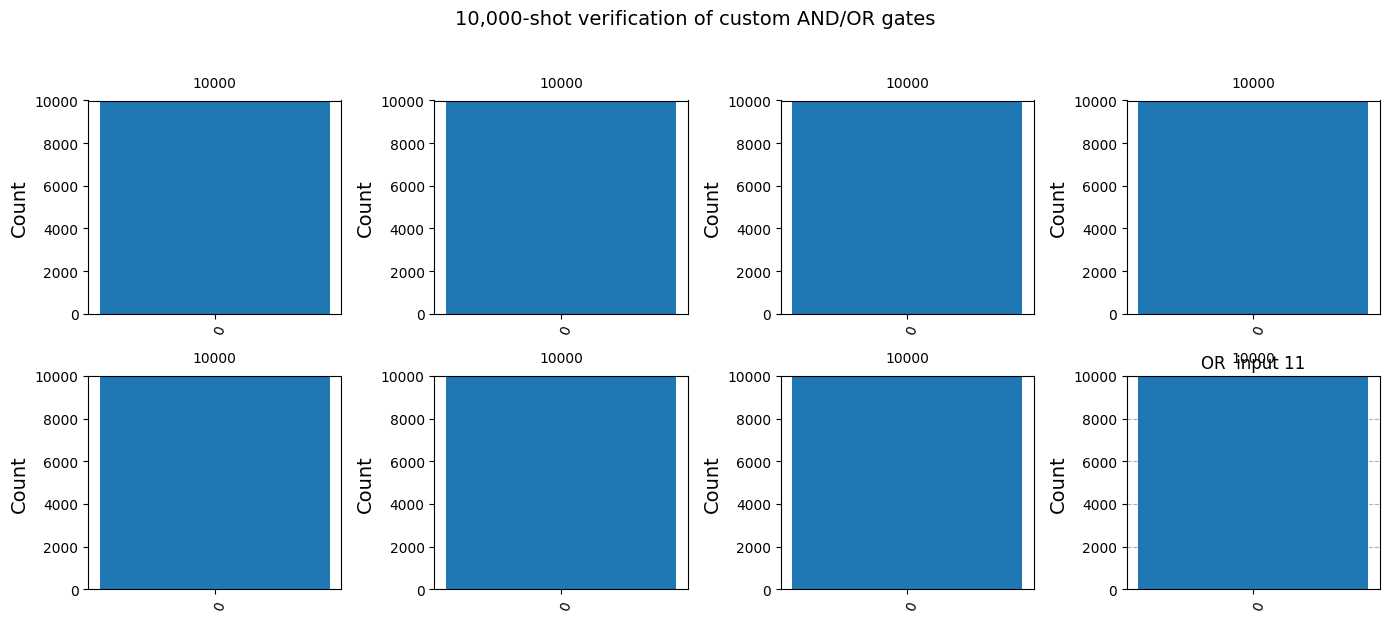

In [46]:

def circuit_with_gate(op: Operator, x: int, y: int, label: str):
    qc = QuantumCircuit(3, 1)   
    if x: qc.x(0)
    if y: qc.x(1)
   
    qc.unitary(op, [0,1,2], label=label)

    qc.measure(2, 0)
    return qc


def run_counts(qc, shots=10_000):
    backend = Aer.get_backend("qasm_simulator")
    job = backend.run(qc, shots=shots)
    return job.result().get_counts()

inputs = [(0,0), (0,1), (1,0), (1,1)]
and_counts = {}
or_counts  = {}

for (x,y) in inputs:
    and_counts[f"{x}{y}"] = run_counts(circuit_with_gate(Op_and, x, y, "AND"))
    or_counts[f"{x}{y}"]  = run_counts(circuit_with_gate(Op_or,  x, y, "OR"))

print("\nAND counts (t bit):")
for k,v in and_counts.items(): print(k, v)
print("\nOR counts (t bit):")
for k,v in or_counts.items(): print(k, v)


fig, axes = plt.subplots(2, 4, figsize=(14, 6))
fig.suptitle("10,000-shot verification of custom AND/OR gates", fontsize=14, y=1.03)

for col, (x,y) in enumerate(inputs):
    key = f"{x}{y}"
    plot_histogram(and_counts[key], ax=axes[0, col], title=f"AND input {key}")
    plot_histogram(or_counts[key],  ax=axes[1, col], title=f"OR  input {key}")
    axes[0, col].set_ylim(0, 10000)
    axes[1, col].set_ylim(0, 10000)

plt.tight_layout()
plt.show()

In [ ]:
AND_gate = Op_and.to_instruction()
AND_gate.label = "AND"
OR_gate  = Op_or.to_instruction()
OR_gate.label = "OR"
qc_and = QuantumCircuit(3, name="Reversible AND")
qc_and.append(AND_gate, [0,1,2])   # acts on [x,y,t]

print(qc_and.draw(output="text"))

qc_or = QuantumCircuit(3, name="Reversible OR")
qc_or.append(OR_gate, [0,1,2])
print(qc_or.draw(output="text"))

     ┌──────┐
q_0: ┤0     ├
     │      │
q_1: ┤1 AND ├
     │      │
q_2: ┤2     ├
     └──────┘
     ┌─────┐
q_0: ┤0    ├
     │     │
q_1: ┤1 OR ├
     │     │
q_2: ┤2    ├
     └─────┘


# Question 2

<ol style="list-style-type:lower-alpha">
    <li>Consider the operator $\mathrm{SWAP}$ defined as<br><br>
        $\hspace{4cm}\mathrm{SWAP}|\psi\rangle |\phi\rangle\ =\ |\phi\rangle |\psi\rangle$, where $|\phi\rangle, |\psi\rangle \in \mathcal{H}^2$.<br><br>
        Create a quantum circuit for the above defined operator using <b>ONLY</b> the basic gates supported by the library $\texttt{qiskit.QuantumCircuit}$, while <b>NEITHER</b> using the $\texttt{swap}$ function from $\texttt{qiskit.QuantumCircuit}$, <b>NOR</b> using the $\texttt{Operator}$ function from the library $\texttt{qiskit.quantum\_info}$.
    </li><br>    
    <li>Visualize the above circuit.</li><br>
    <li>Using the $\verb|statevector_simulator|$ from $\verb|Aer|$, simulate your circuit and perform measurements.</li>
</ol>

In [84]:
def run_counts(qc, shots=10_000):
    backend = Aer.get_backend("qasm_simulator")
    job = backend.run(qc, shots=shots)
    return job.result().get_counts()

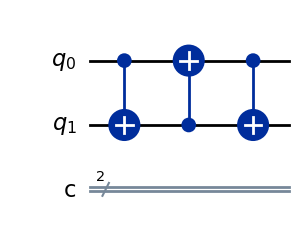

In [130]:
swap_circuit = QuantumCircuit(2, 2)
swap_circuit.cx(0, 1)
swap_circuit.cx(1, 0)
swap_circuit.cx(0, 1)

(swap_circuit.draw(output="mpl"))


In [128]:
def ciruit_measurement(qc: QuantumCircuit, q0: int, q1: int):
    
    qc = QuantumCircuit(2, 2)
    
    if q0: 
        qc.x(0)
    if q1:
        qc.x(1)
        
    qc.cx(0, 1)
    qc.cx(1, 0)
    qc.cx(0, 1)

    print(qc.draw(output="text"))
    
    qc.measure(0, 1)
    qc.measure(1, 0)
    
    return qc

In [129]:
inputs = [(0, 0), (1, 1), (1, 0), (0, 1)]

for q0, q1 in inputs:
    m = run_counts(ciruit_measurement(swap_circuit, q0, q1))
    print(f"input: {(q0, q1)} :: {m}")
    
    

          ┌───┐     
q_0: ──■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├
     └───┘     └───┘
c: 2/═══════════════
                    
input: (0, 0) :: {'00': 10000}
     ┌───┐     ┌───┐     
q_0: ┤ X ├──■──┤ X ├──■──
     ├───┤┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├┤ X ├──■──┤ X ├
     └───┘└───┘     └───┘
c: 2/════════════════════
                         
input: (1, 1) :: {'11': 10000}
     ┌───┐     ┌───┐     
q_0: ┤ X ├──■──┤ X ├──■──
     └───┘┌─┴─┐└─┬─┘┌─┴─┐
q_1: ─────┤ X ├──■──┤ X ├
          └───┘     └───┘
c: 2/════════════════════
                         
input: (1, 0) :: {'01': 10000}
               ┌───┐     
q_0: ───────■──┤ X ├──■──
     ┌───┐┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├┤ X ├──■──┤ X ├
     └───┘└───┘     └───┘
c: 2/════════════════════
                         
input: (0, 1) :: {'10': 10000}


# Question 3

## Superdense Coding

### 3.1. The Difference between Superdense Coding and Quantum Teleportation <a id='difference'></a>

Quantum teleportation and superdense coding are closely related, but to avoid the confusion between the two, we need to clarify the difference.

Quantum teleportation is a process by which the state of qubit ($|\psi\rangle$) can be transmitted from one location to another, using two bits of classical communication and a Bell pair. In other words, we can say it is a protocol that destroys the quantum state of a qubit in one location and recreates it on a qubit at a distant location, with the help of a shared entangled pair, while communicating two classical bits. Superdense coding is a procedure that allows someone to send two classical bits of information to another party by simply communicating a single qubit.

| Teleportation                                     | Superdense Coding                                    |
|:-------------------------------------------------:|:----------------------------------------------------:|
| Transmit one qubit of information <br> using two classical bits | Transmit two classical bits<br> of information using one qubit |


The teleportation protocol can be thought of as a flipped version of the superdense coding protocol, in the sense that Alice and Bob merely “swap their equipment.”



### 3.2. The Process <a id='process'></a>

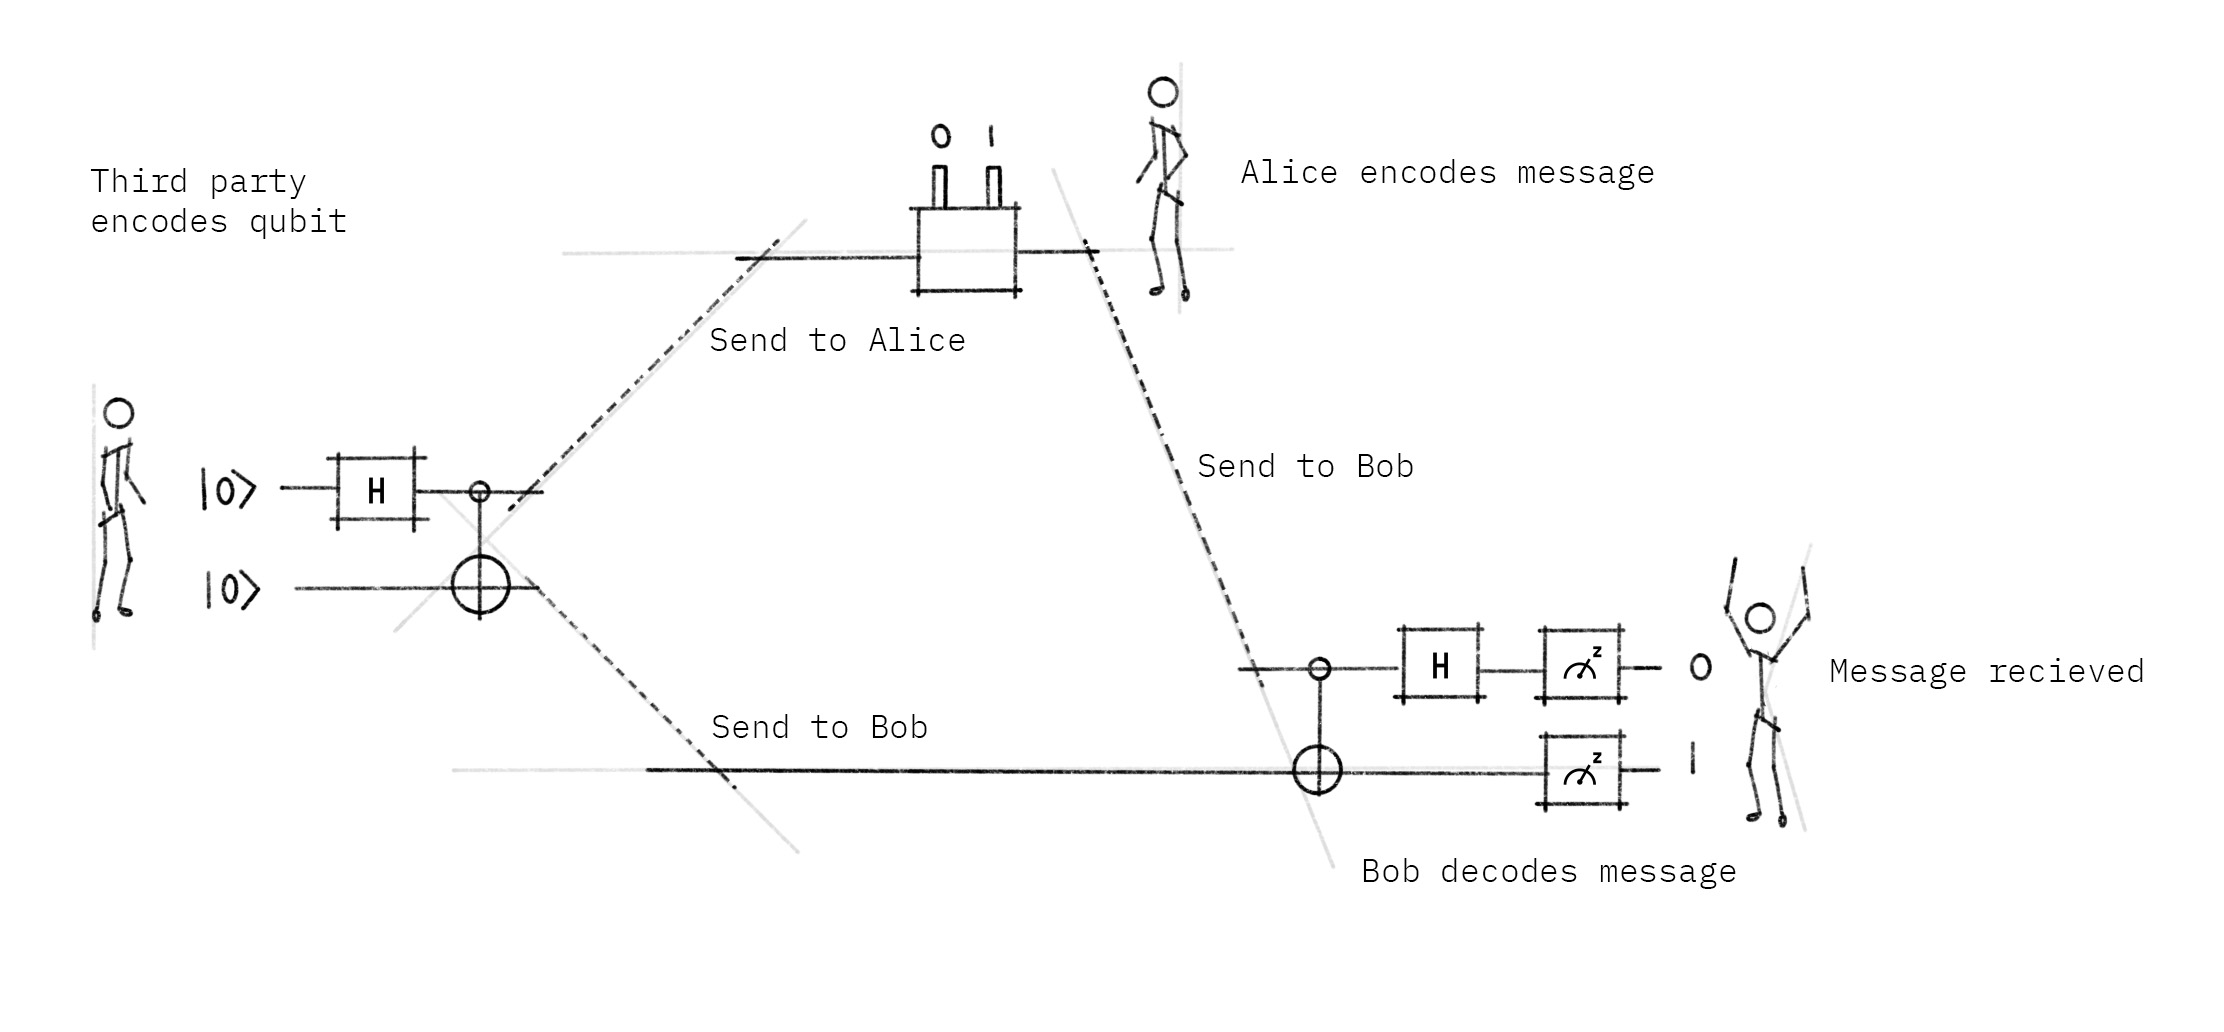

#### 3.2.1. Step 1 <a id='step1'></a>
Before the process starts, Alice and Bob meet at some location and prepare the Bell state $|\Phi^+\rangle\ =\ \dfrac{|00\rangle+|11\rangle}{\sqrt{2}}$. Alice take the first qubit, while Bob picks up the second qubit, and both go on their seperate ways.


#### 3.2.2. Step 2 (Encoding Rules for Superdense Coding - Alice's protocol) <a id='step2'></a>

Now, the goal of the protocol is for Alice to send two classical bits of information to Bob by sending him only her qubit. But before she does, she needs to apply a set of quantum gates to her qubit depending on the two bits of information she wants to send:

<table>
    <tr>
        <th>Intended Message</th>
        <th>Applied Gate (on Alice's qubit)</th>
    </tr>
    <tr>
        <td>00</td>
        <td>$I$</td>
    </tr>
    <tr>
        <td>01</td>
        <td>$X$</td>
    </tr>
    <tr>
        <td>10</td>
        <td>$Z$</td>
    </tr>
    <tr>
        <td>11</td>
        <td>$ZX$</td>
    </tr>
</table>


#### 3.2.3. Step 3 (Decoding Rules for Superdense Coding - Bob's protocol) <a id='step3'></a>

Bob receives Alice's qubit, and uses his qubit to decode Alice's message. Notice that he does not need to have knowledge of the state Alice's qubit is in in order to decode the message — he simply uses some restoration operations - 

<ol>
      <li>Apply a CNOT gate using Alice's qubit as control and Bob's qubit as target,</li>
      <li>Apply a Hadamard gate on Bob's qubit,</li>
      <li>Perform measurement on both qubits - this is Alice's message.</li>
</ol>

Create a function that outputs a qiskit $\texttt{QuantumCircuit}$ representing the Bell state $|\Phi^+\rangle\ =\ \dfrac{|00\rangle+|11\rangle}{\sqrt{2}}$.

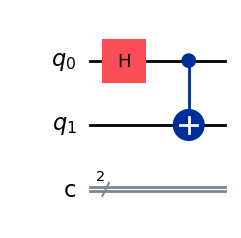

In [104]:
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)

qc.draw(output="mpl")

Next we need to encode Alice's message. We saw that there were four possible messages Alice could send: `00`, `10`, `01` or `11`. Create a function that takes as input Alice's message, and the above created qiskit $\texttt{QuantumCircuit}$ representing the Bell state $|\Phi^+\rangle$, and outputs a suitably encoding entangled pair of qubits as per her protocol.

In [108]:
input = (0, 1)

In [109]:
def encode_message(first_bit:int, second_bit: int, qc: QuantumCircuit) -> QuantumCircuit:
    
    if first_bit:
        qc.z(0)
    if second_bit:
        qc.x(0)
   
    return qc
    

Create a function that decodes the message correctly as per Bob's protocol.

In [110]:
def decode_message(qc: QuantumCircuit) -> QuantumCircuit:
    
    qc.cx(0, 1)
    qc.h(1)
    
    return qc
    

Put all the above components together, and perform measurement on all the qubits. Plot a histogram over 10,000 such measurements over different random messages to show that the protocol indeed works correctly. 

In [126]:
def measurement(first_bit: int, second_bit: int):
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    
    if second_bit:
        qc.x(0)
    if first_bit:
        qc.z(0)

    
    qc.cx(0, 1)
    qc.h(0)

    qc.measure(0, 1)
    qc.measure(1, 0)
    # print(qc.draw(output="text"))
    
    return qc

In [131]:
inputs = [(0, 0), (1, 1), (1, 0), (0, 1)]

for q0, q1 in inputs:
    m = run_counts(measurement(q0, q1))
    print(f"input: {(q0, q1)} :: output: {m}")

input: (0, 0) :: output: {'00': 10000}
input: (1, 1) :: output: {'11': 10000}
input: (1, 0) :: output: {'10': 10000}
input: (0, 1) :: output: {'01': 10000}
